In [12]:
# Add the root path of the pyqula library
import os ; import sys
try: sys.path.append(os.environ["PYQULAROOT"]) # add the library via environmental variable
except: 
    try: from pyqula import geometry # check if the library is present
    except: #print("Install pyqula with\npip install --upgrade pyqula") # pyqula must be installed
    # you can uncomment the following lines to install it automatically
        print("pyqula needs to be installed, installing it")
        import subprocess ; subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade","pyqula"])

# some default parameters in matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['font.size'] = 22
plt.rcParams['image.cmap'] = 'coolwarm'


import numpy as np

# Session 2: Symmetries, reciprocal space and Bloch's theorem
In this session we will address the emergence of electronic structures, and symmetry breaking driven by interactions

### Contents
- From finite to infinite systems, and emergence of bandstructures
- Energy spectra of chains and ribbons
- Gap opening driven many-body interactions
- Spontaneous time-reversal symmetry breaking in the Hubbard model
- Spontaneous translational symmetry breaking from nearest-neighbor repulsion


## Finite size chains
We will now see how the spectra of a finite chain evolves with its length

Text(0, 0.5, 'Energy')

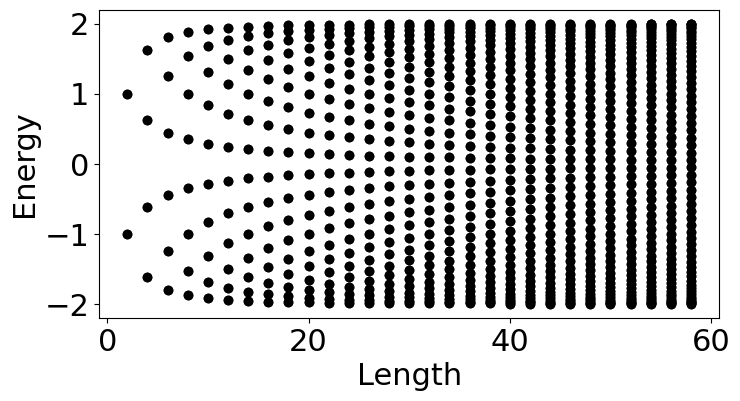

In [2]:
from pyqula import geometry
fig = plt.figure(figsize=(8,4))

Ls = range(2,60,2) # different lengths

for L in Ls:
    g = geometry.chain() # generate a chain
    g = g.get_supercell(L) # make a supercell
    g.dimensionality = 0 # make it finite
    h = g.get_hamiltonian() # generate the Hamiltonian
    (k,e) = h.get_bands() # compute band structure
    plt.scatter(e*0. + L,e,c="black")
plt.xlabel("Length") ; plt.ylabel("Energy")

### Quiz
- Why the number of eigenvalues increases with the system size?
- Make a log plot of the gap and obtain its functional dependence with the system size

## Density of states of a finite system as a function of the system size
We will now see how the size of a system influences its density of states

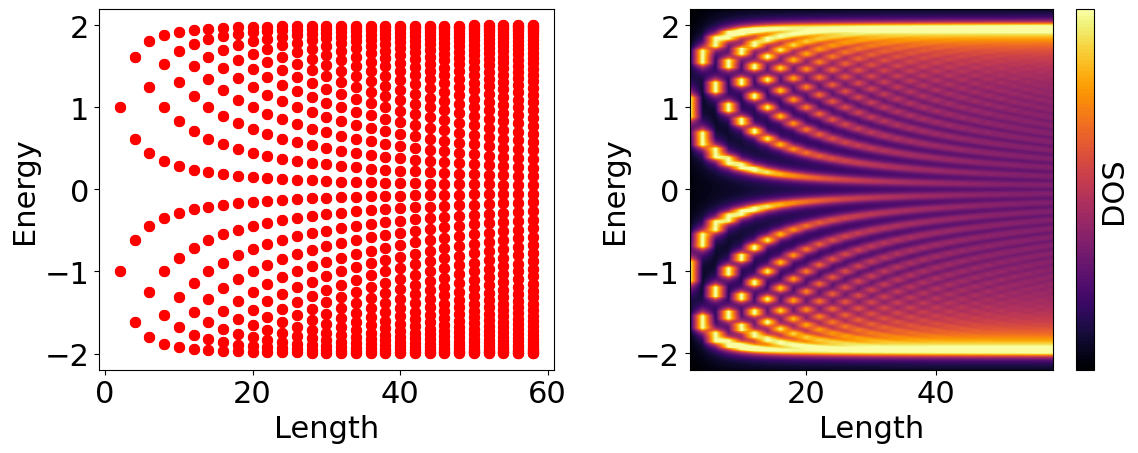

In [3]:
fig = plt.figure(figsize=(12,5))

Ls = range(2,60,2) # different lengths

ii = 0 # counter

edos = np.linspace(-2.2,2.2,300) # energies for the DOS
dos_array = [] # array for the DOS


plt.subplot(1,2,1)
    
for L in Ls:
    g = geometry.chain() # generate a chain
    g = g.get_supercell(L) # make a supercell
    g.dimensionality = 0 # make it finite
    h = g.get_hamiltonian() # generate the Hamiltonian
    def vper(r): # add a modulated onsite energy
        V = 0. # strength of the modulation
        return V*np.cos(np.pi*np.sqrt(2)*r[0]) # incommensurate spatially dependent onsite
    h.add_onsite(vper) # add a modualted onsite energy
    (k,e) = h.get_bands() # compute band structure
    (ei,ddos) = h.get_dos(energies=edos)
    plt.scatter(e*0. + L,e,c="red",s=50)
    dos_array.append(ddos/L) # store

plt.xlabel("Length") ; plt.ylabel("Energy")    

# plot the DOS
plt.subplot(1,2,2)
c = ii/len(Ls) # float for the color of the plot
dosz = np.array(dos_array).T ; vmax = 1.0 ; dosz[dosz>vmax] = vmax # saturate scale
plt.contourf(Ls,edos,dosz,levels=100,cmap="inferno") 
plt.colorbar(label="DOS",ticks=[],boundaries=[0,0.5,1])
plt.xlabel("Length") ; plt.ylabel("Energy") 


plt.tight_layout()

### Quiz
- Make the system even bigger, what happens with the density of states?
- What is the dispersion relation in the thermodynamic limit?
- Add a finite modulated onsite energy V, what happens to the spectra of the chain?

## Bandstructure of a tight binding chain, ladder and ribbons
We will start showing the magnetic instabilities of a 1D chain at half filling, with two sites per unit cell

([], [])

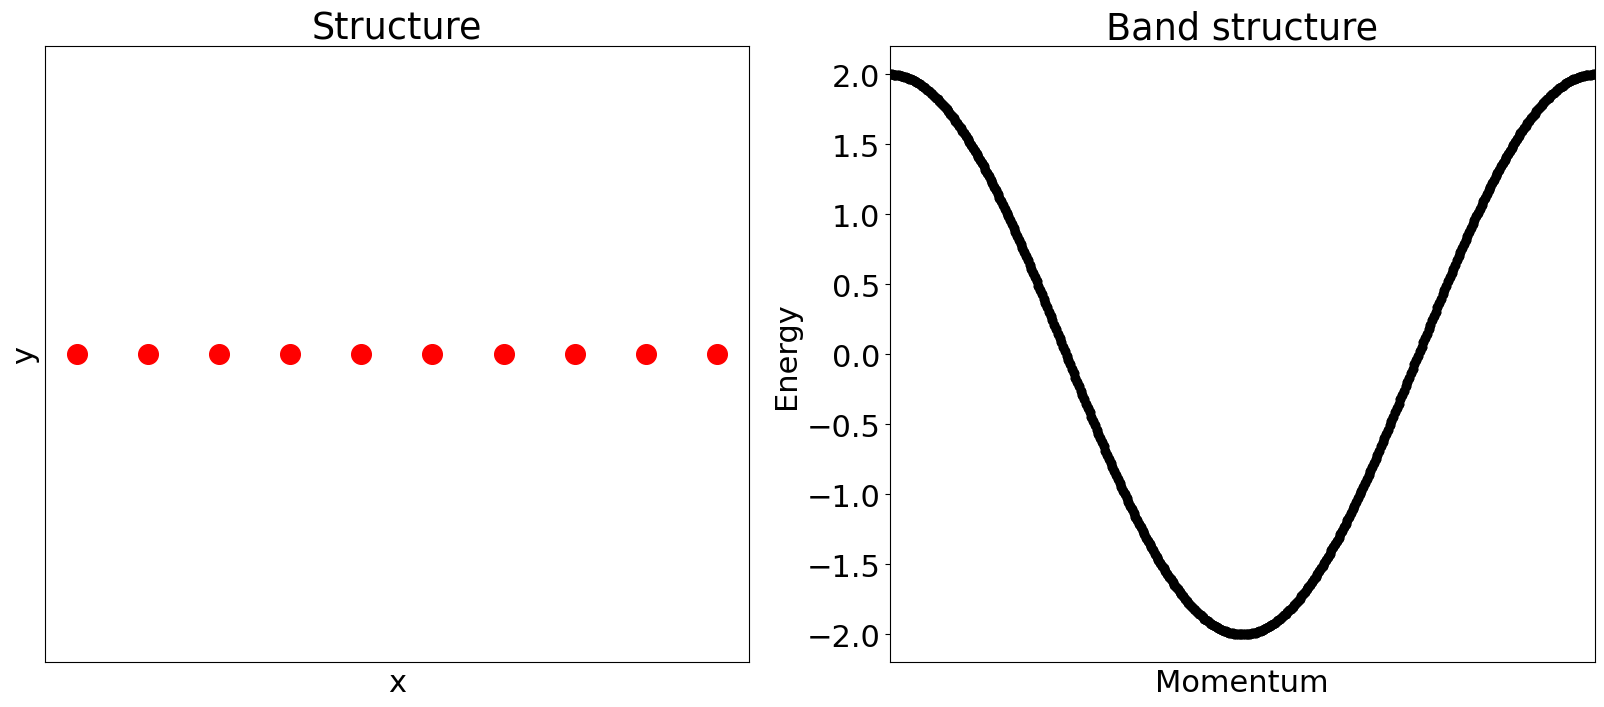

In [4]:
from pyqula import geometry
g = geometry.chain() # generate a chain
#g = geometry.ladder() # generate a ladder
#g = geometry.honeycomb_zigzag_ribbon(8) # generate a zigzag honeycomb ribbon of width 8

plt.subplot(1,2,1) # plot the geometry
NS = 10 # size of the supercell to plot
gs = g.get_supercell(NS) # make a supercell
plt.scatter(gs.r[:,0],gs.r[:,1],s=200,c="red") 
plt.title("Structure")
plt.xticks([]) ; plt.yticks([]) ; plt.axis("equal") ; plt.xlabel("x") ; plt.ylabel("y")

plt.subplot(1,2,2) # plot the bands
plt.title("Band structure")
h = g.get_hamiltonian() # generate the Hamiltonian
(k,e) = h.get_bands() # compute band structure
plt.xlim([min(k),max(k)]) # adjust plot
plt.scatter(k,e,c="black") ; plt.xlabel("Momentum") ; plt.ylabel("Energy") ; plt.xticks([]) # plot

### Quiz
- What is the functional form of the electronic dispersion for the chain?
- Replace the chain by a ladder, what is its electronic dispersion?
- Replace the chain by a honeycomb ribbon, how does the dispersion look like and what do you see that seems special?

## Magnetic order driven by interactions in a chain

(np.float64(-3.85),
 np.float64(3.85),
 np.float64(-0.05500000000000001),
 np.float64(0.05500000000000001))

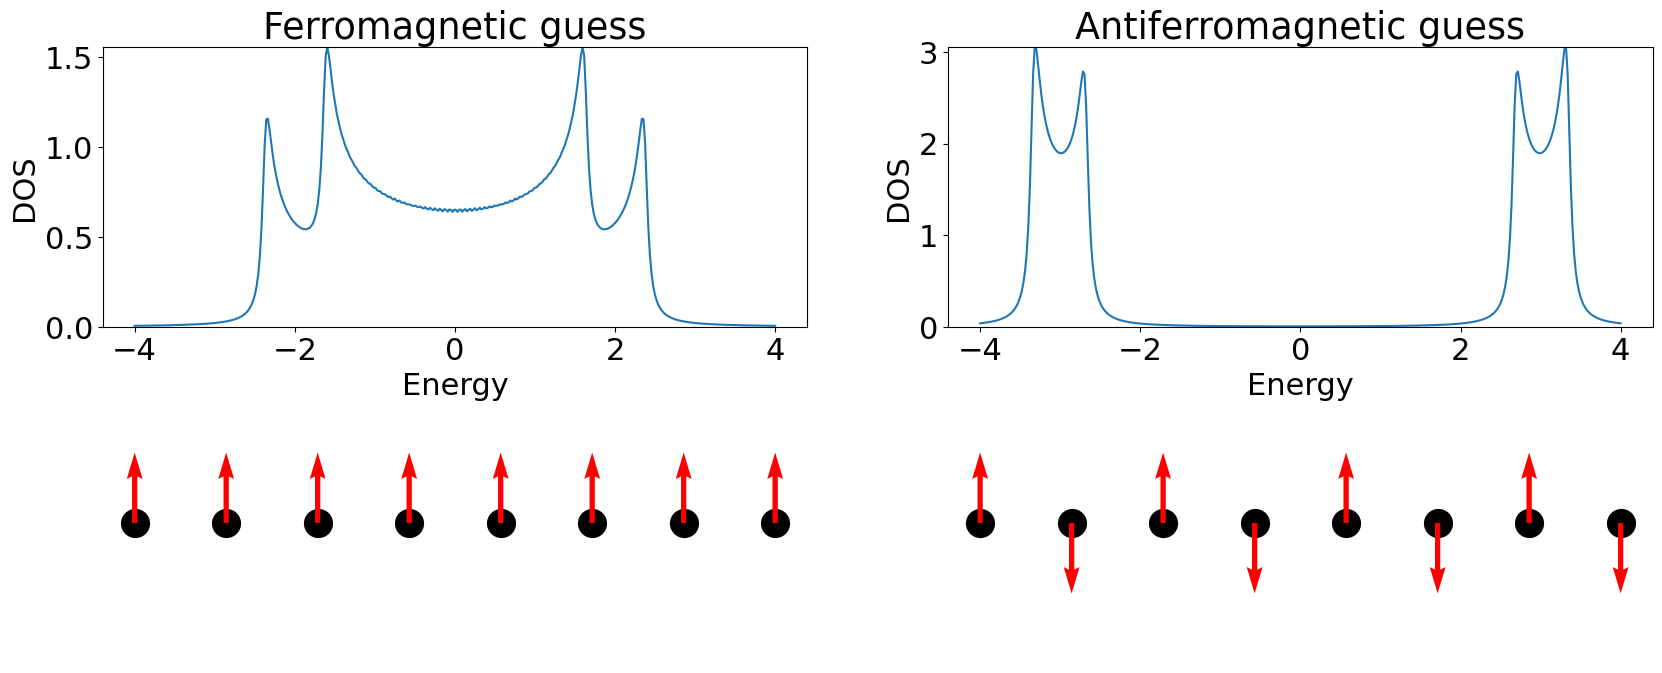

In [5]:
# let us now add interactions, and compute the electronic structure
from pyqula import geometry
g = geometry.bichain() # generate a chain with two sites per unit cell (with internal sublattice)
h = g.get_hamiltonian() # generate the Hamiltonian

U = 6.0 # value of the local interaction

# first with a ferromagnetic guess, DOS
plt.subplot(2,2,1)
plt.title("Ferromagnetic guess")
hfe = h.get_mean_field_hamiltonian(U=U,mf="ferro") # solve the interacting problem with a mean-field guess
(es,ds) = hfe.get_dos() # compute DOS
plt.plot(es,ds)
plt.xlabel("Energy") ; plt.ylabel("DOS") ; plt.ylim([0,max(ds)])

# plot magnetization
hs = hfe.get_supercell(4) ; gs = hs.geometry ; mz = hs.extract("mz") # supercell geometry and Mz
plt.subplot(2,2,3)
mz = hs.extract("mz") ; x = gs.r[:,0] ; y = gs.r[:,1] 
mz = mz/np.max(np.abs(mz)) # normalize
plt.scatter(x,y,c="black",s=400) ; plt.quiver(x,y,0.,mz,color="red",scale=10) ; plt.axis("off") # plot

# and with an antiferromagnetic guess
plt.subplot(2,2,2)
plt.title("Antiferromagnetic guess")
haf = h.get_mean_field_hamiltonian(U=U,mf="antiferro") # solve the interacting problem with a mean-field guess
(es,ds) = haf.get_dos() # compute DOS
plt.plot(es,ds)
plt.xlabel("Energy") ; plt.ylabel("DOS") ; plt.ylim([0,max(ds)])

# plot magnetization
hs = haf.get_supercell(4) ; gs = hs.geometry ; mz = hs.extract("mz") # supercell geometry and Mz
plt.subplot(2,2,4)
mz = hs.extract("mz") ; x = gs.r[:,0] ; y = gs.r[:,1] 
mz = mz/np.max(np.abs(mz)) # normalize
plt.scatter(x,y,c="black",s=400) ; plt.quiver(x,y,0.,mz,color="red",scale=10) ; plt.axis("off") # plot

### Quiz
- Discuss which solution you think it has the lowest energy, and why
- Compute the selfconsistent solution for stronger values of the interaction. Which change do you observe?

## The spectra of a dimer
Here we will review the electronic spectra of a tight binding dimer

Text(0.5, 0, 'State index')

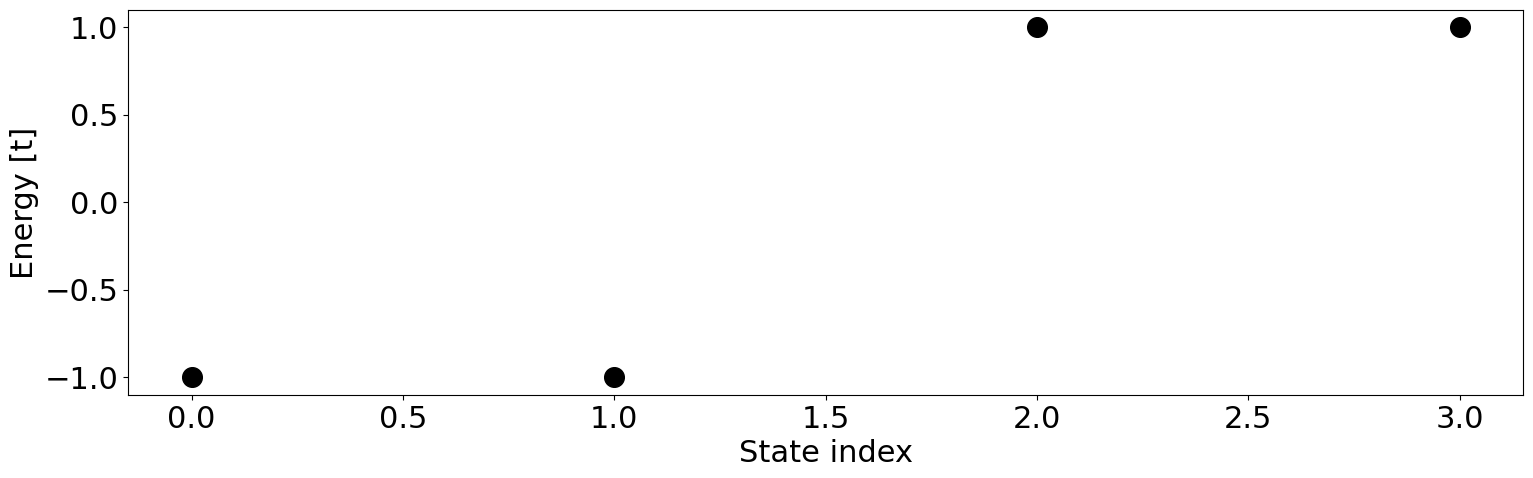

In [6]:
from pyqula import geometry
g = geometry.bichain() # generate a chain with two sites per unit cell (with internal sublattice)
g.dimensionality = 0 # just retain the two sites per unit cell

plt.figure(figsize=(18,5))
h = g.get_hamiltonian(has_spin=True) # generate Hamiltonian

(ks,es) = h.get_bands() # get bands
plt.scatter(range(len(es)),es,c="black",s=200) ; plt.ylabel("Energy [t]") ; plt.xlabel("State index")

### Quiz
- There two sites in the system, why do we have four eigenstates?
- Why are the state degenerate in energy?

## The interacting Hubbard dimer
Here we will see how the magnetization evolves in an interacting dimer chain

Text(0, 0.5, '$\\langle S_z \\rangle $')

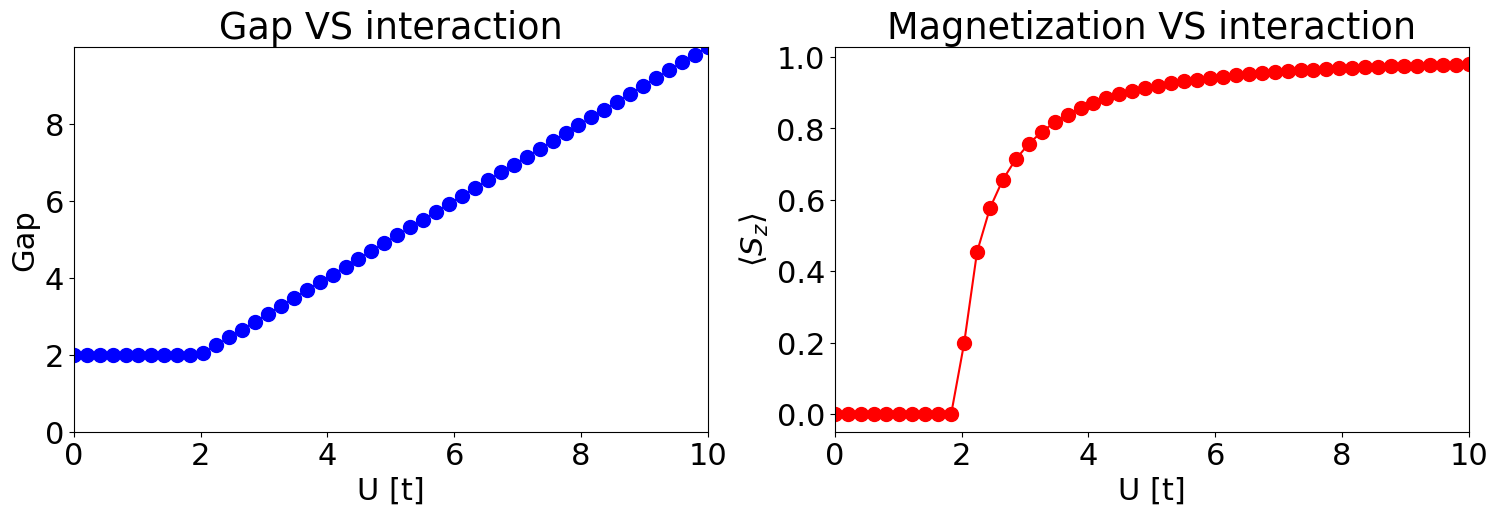

In [7]:
from pyqula import geometry
g = geometry.bichain() # generate a chain with two sites per unit cell (with internal sublattice)
L = 1 # size of the system
g = g.get_supercell(L) # make a supercell
g.dimensionality = 0 # just retain the two sites per unit cell
h0 = g.get_hamiltonian() # generate the Hamiltonian

Us = np.linspace(0.,10.,50) # number of interactions
mzs = [] # empty list for magnetizations
gaps = [] # gaps of the systems
for U in Us:
    h = h0.get_mean_field_hamiltonian(U=U,mf="antiferro",mix=0.9) # perform SCF
    mz = h.get_vev("mz")[1] # magnetization of the second site
    mzs.append(abs(mz)) # store magnetization in that size
    gaps.append(h.get_gap()) # compute gap of the system and store it


plt.figure(figsize=(18,5))

plt.subplot(1,2,1) # plot the magnetization VS interaction
plt.title("Gap VS interaction")
plt.plot(Us,gaps,marker="o",c="blue",markersize=10) ; plt.xlim([min(Us),max(Us)])
plt.xlabel("U [t]") ; plt.ylabel("Gap") ; plt.ylim([0,max(gaps)])

plt.subplot(1,2,2) # plot the magnetization VS interaction
plt.title("Magnetization VS interaction")
plt.plot(Us,mzs,marker="o",c="red",markersize=10) ; plt.xlim([min(Us),max(Us)])
plt.xlabel("U [t]") ; plt.ylabel("$\\langle S_z \\rangle $")

### Quiz
- Identify the non-interacting and strongly interacting limit in the plot
- Why does the magnetization saturate at large interactions?
- Why is there a critical value to have magnetization?
- Why is there a gap even when there is no magnetization?
- Make the system bigger. WHat happens, and why?

## Gap opening in the Hubbard model
We will now see how the Hubbard interaction give rise to a gap opening in an interacting chain

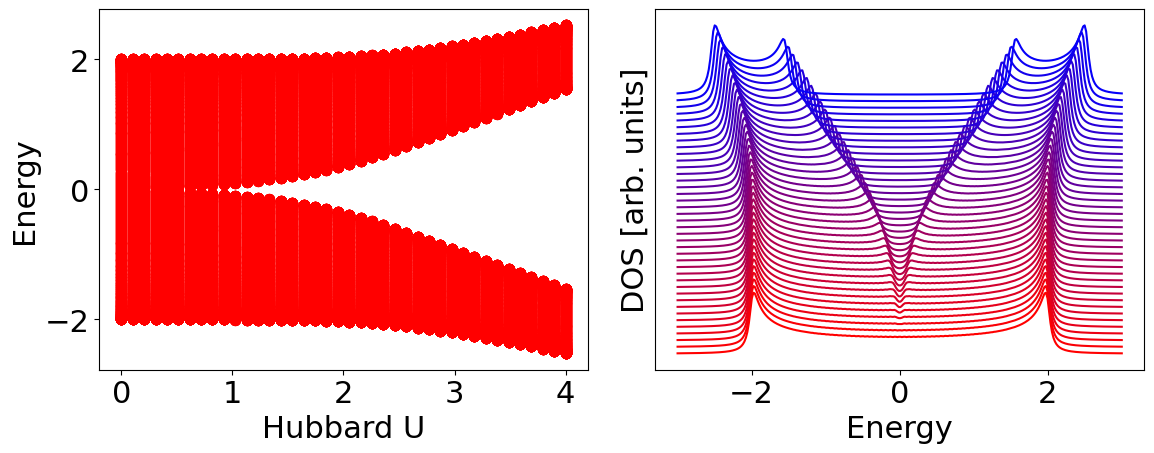

In [8]:
fig = plt.figure(figsize=(12,5))

Us = np.linspace(0.,4.0,40)

g = geometry.bichain() # generate a chain
h0 = g.get_hamiltonian() # generate the Hamiltonian
iU = 0 # counter
for U in Us:
    h = h0.get_mean_field_hamiltonian(U=U,mf="antiferro",mix=0.9) # perform SCF
#    h = h0.get_mean_field_hamiltonian(U=U,mf="ferro",mix=0.9) # perform SCF, with a ferromagnetic initialization
    (k,e) = h.get_bands() # compute band structure
    edos = np.linspace(-3,3.,300) # energies for the DOS
    (edos,ddos) = h.get_dos(energies=edos)
    plt.subplot(1,2,1)
    plt.scatter(e*0. + U,e,c="red",s=50)
    plt.subplot(1,2,2)
    c = iU/len(Us) # float for the color of the plot
    plt.plot(edos,ddos+iU/4.,c=(1-c,0,c))
    iU += 1
plt.subplot(1,2,1)
plt.xlabel("Hubbard U") ; plt.ylabel("Energy")

plt.subplot(1,2,2)
plt.xlabel("Energy") ; plt.ylabel("DOS [arb. units]") ; plt.yticks([])

plt.tight_layout()

### Quiz
- Use a ferromagnetic initialization, what happens and why?

## Gap opening in the Hubbard model on the honeycomb lattice
We will now see how the Hubbard interaction give rise to a gap opening in an interacting honeycomb lattice

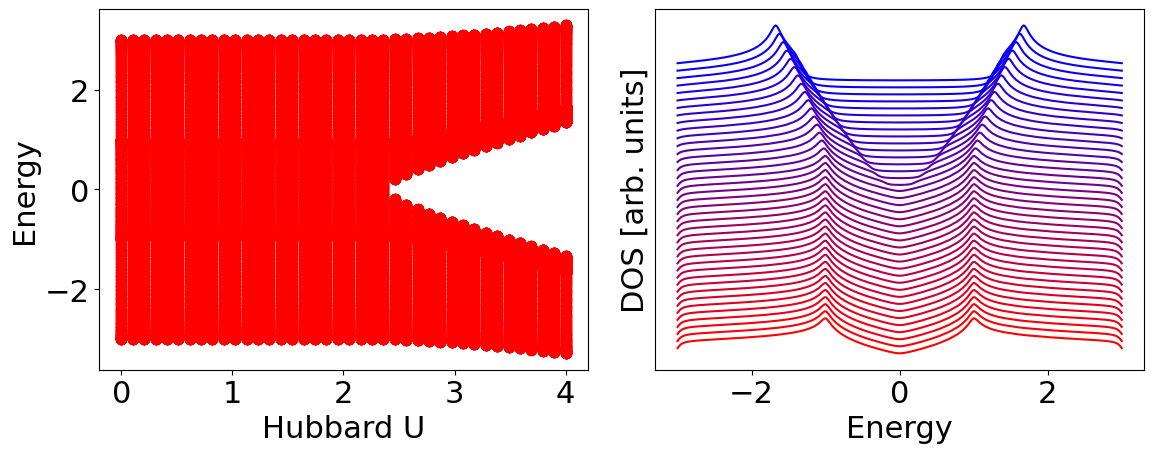

In [9]:
fig = plt.figure(figsize=(12,5))

Us = np.linspace(0.,4.0,40)

g = geometry.honeycomb_lattice() # generate a honeycomb lattice
#g = geometry.square_lattice_bipartite() # generate a square lattice (with internal sublattice)
h0 = g.get_hamiltonian() # generate the Hamiltonian
iU = 0 # counter
for U in Us:
    h = h0.get_mean_field_hamiltonian(U=U,mf="antiferro",mix=0.9,nk=10) # perform SCF
#    h = h0.get_mean_field_hamiltonian(U=U,mf="ferro",mix=0.9) # perform SCF, with a ferromagnetic initialization
    (k,e) = h.get_bands() # compute band structure
    edos = np.linspace(-3,3.,300) # energies for the DOS
    (edos,ddos) = h.get_dos(energies=edos)
    plt.subplot(1,2,1)
    plt.scatter(e*0. + U,e,c="red",s=50)
    plt.subplot(1,2,2)
    c = iU/len(Us) # float for the color of the plot
    plt.plot(edos,ddos+iU/4.,c=(1-c,0,c))
    iU += 1
plt.subplot(1,2,1)
plt.xlabel("Hubbard U") ; plt.ylabel("Energy")

plt.subplot(1,2,2)
plt.xlabel("Energy") ; plt.ylabel("DOS [arb. units]") ; plt.yticks([])

plt.tight_layout()

### Quiz
- What difference do you see with respect to the linear chain above?
- At which value of the interaction you think that you have symmetry breking?
- Replace the honeycomb lattice by a square lattice. How is it different from the honeycomb lattice?

## Gap opening in a spinless interacting model
We will now see how in a spinless model, a gap opening appears in the presence of interactions

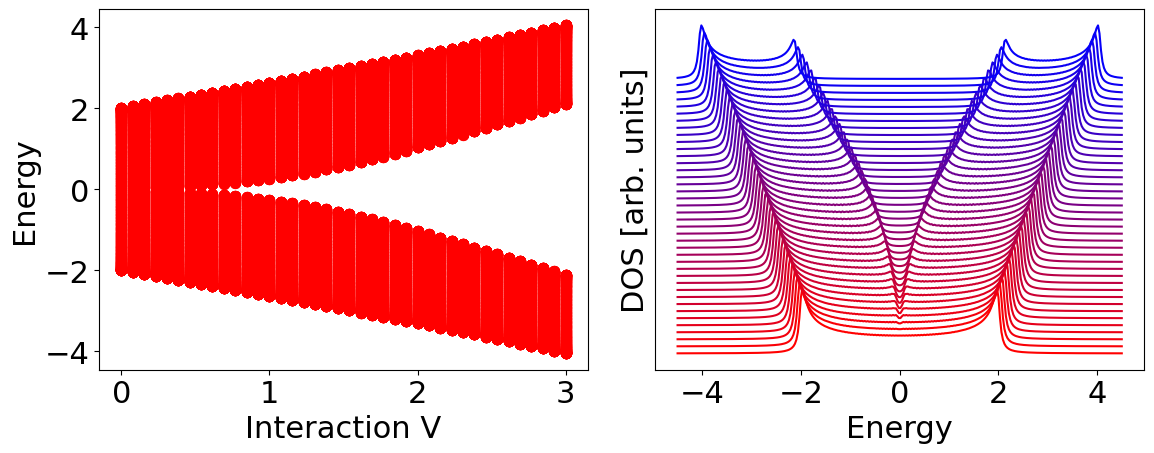

In [10]:
fig = plt.figure(figsize=(12,5))

Vs = np.linspace(0.,3.0,40)
g = geometry.bichain() # generate a chain with two sites
h0 = g.get_hamiltonian(has_spin=False) # generate the Hamiltonian
cdw = 0. # external CDW
h0.add_sublattice_imbalance(cdw) # add an external CDW

iV = 0

edos = np.linspace(-4.5,4.5,300) # energies for the DOS

for V in Vs:
    h = h0.get_mean_field_hamiltonian(V1=V,mf="CDW",mix=0.9,filling=0.5) # perform SCF
    (k,e) = h.get_bands() # compute band structure
    (edos,ddos) = h.get_dos(energies=edos)
    plt.subplot(1,2,1)
    plt.scatter(e*0. + V,e,c="red",s=50)
    plt.subplot(1,2,2)
    c = iV/len(Us) # float for the color of the plot
    plt.plot(edos,ddos+iV/8.,c=(1-c,0,c))
    iV += 1
plt.subplot(1,2,1)
plt.xlabel("Interaction V") ; plt.ylabel("Energy")

plt.subplot(1,2,2)
plt.xlabel("Energy") ; plt.ylabel("DOS [arb. units]") ; plt.yticks([])

plt.tight_layout()

### Quiz
- Why does the gap increase with the interaction strength?
- Add some charge density wave (cdw) externally to the system, what do you observe and why?

## Symmetry breaking in the spinless fermionic chain
We will now see how interactions create a charge imbalance in the interacting spinless model

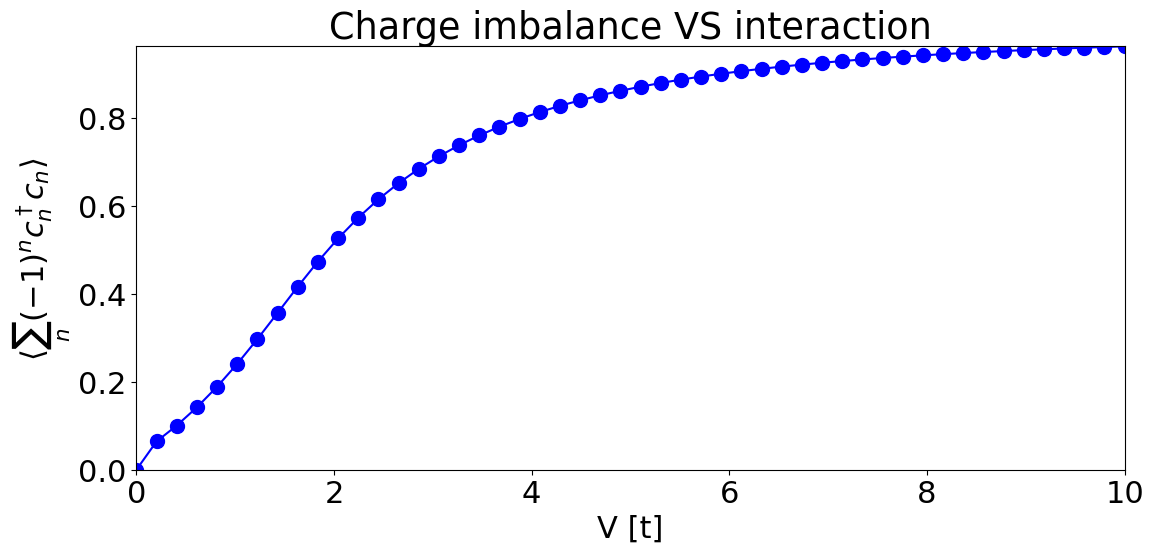

In [11]:
from pyqula import geometry
g = geometry.bichain() # generate a chain with two sites per unit cell (with internal sublattice)
h0 = g.get_hamiltonian(has_spin=False) # generate the Hamiltonian
cdw = 0. # external CDW
h0.add_sublattice_imbalance(cdw) # add an external CDW


Vs = np.linspace(0.,10.,50) # number of interactions
dens = [] # empty list for magnetizations
for V in Vs:
    h = h0.get_mean_field_hamiltonian(V1=V,mf="CDW",mix=0.5,filling=0.5) # perform SCF
    den = h.get_vev(operator=None) # magnetization of the second site
    dens.append(abs(den[0]-den[1])) # store magnetization in that size

    
plt.figure(figsize=(12,6))

plt.title("Charge imbalance VS interaction")
plt.plot(Vs,dens,marker="o",c="blue",markersize=10) ; plt.xlim([min(Vs),max(Vs)])
plt.xlabel("V [t]") ; plt.ylabel("$\\langle \\sum_n (-1)^n c^\\dagger_n c_n \\rangle $") ; plt.ylim([0,max(dens)])
plt.tight_layout()


### Quiz
- Why does the charge imbalance sature to 1 for large interactions?
- Add some CDW externally to the system, what do you observe and why?